In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [17, 6]
from IPython.display import Audio

In [2]:
import numpy as np
import torch
import scipy.signal
from librosa.display import waveshow
import librosa

In [3]:
from rt_ddsp.synths import FilteredNoise
from rt_ddsp import core

In [4]:
n_samples = 32000
sample_rate = 16000
n_bands = 100

# I might need to re-implement the `FilteredNoise` class

Everything required to implement one is below.

Also I might need to try a different overlapping windowing strategy. Just a flat (boxcar) window along the slice, with two halves of hann windows on the side. But hiss seems to be a waste of time now.

In [5]:
signal = np.random.uniform(low=-1.0, high=1.0, size=n_samples)

In [6]:
Audio(signal, rate=sample_rate, normalize=True)

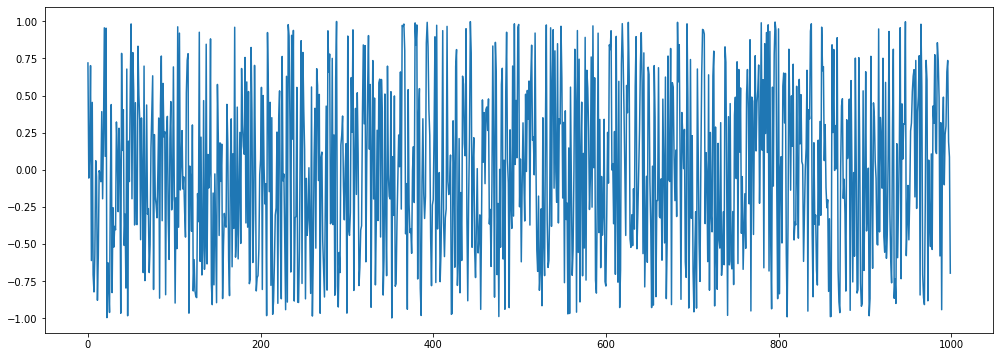

In [7]:
plt.plot(signal[:1000])
plt.show()

In [8]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

In [9]:
def padded_hann(n):
    hann = np.hanning(80)
    l_pad = 1 + n * 80
    r_pad = 8000 - (n + 1) * 80
    return np.pad(hann, (l_pad, r_pad))

In [10]:
def padded_hann(n):
    hann = np.hanning(160)
    l_pad = n * 80 - 80
    if l_pad < 0:
        l_pad = 0
        hann = hann[80:]
    r_pad = 8000 - (n + 1) * 80
    if r_pad < 0:
        r_pad = 0
        hann = hann[:80]
    return np.pad(hann, (l_pad + 1, r_pad))

In [11]:
one_bands = [5, 6, 12, 20, 21, 22, 23, 24, 25]

In [12]:
fdg_filter = sum([padded_hann(i) for i in one_bands])

In [13]:
fdg_filter.shape

(8001,)

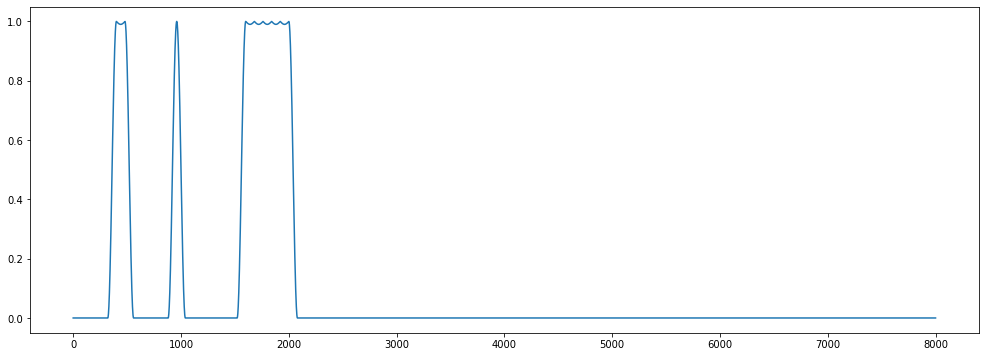

In [14]:
plt.plot(fdg_filter)
plt.show()

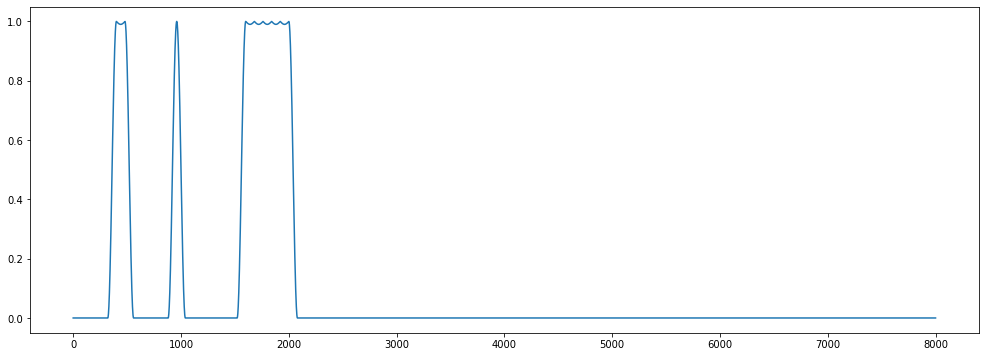

In [15]:
plt.plot(fdg_filter)
plt.show()

In [16]:
tdg_filter = np.fft.irfft(fdg_filter)
tdg_filter = np.fft.fftshift(tdg_filter)

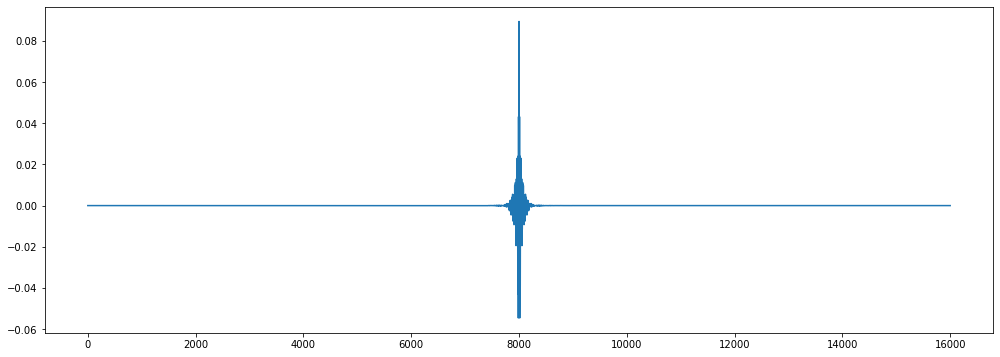

In [17]:
plt.plot(tdg_filter)
plt.show()

In [18]:
signal.shape, tdg_filter.shape

((32000,), (16000,))

In [19]:
padded_signal = np.pad(signal, (len(tdg_filter), len(tdg_filter)))

In [20]:
result = np.convolve(padded_signal, tdg_filter, 'valid')
result = result[8000:-8001]
result.shape

(32000,)

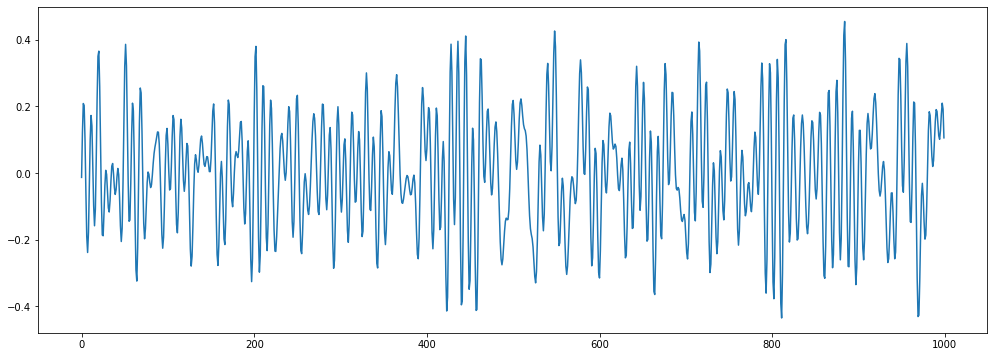

In [21]:
plt.plot(result[:1000])
plt.show()

In [22]:
Audio(result, rate=sample_rate)

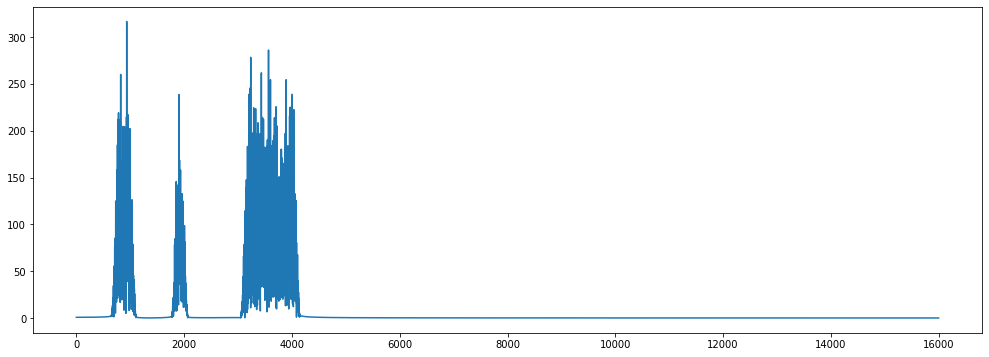

In [23]:
plt.plot(np.abs(np.fft.rfft(result)))
plt.show()

In [24]:
result_fft = np.abs(np.fft.rfft(result))
bands = np.array([np.sum(result_fft[i * (len(result_fft) // n_bands):(i + 1) * (len(result_fft) // n_bands)]) for i in range(n_bands)])

In [25]:
def cosine_similarity(x, y):
    return (x @ y) / (np.linalg.norm(x) * np.linalg.norm(y))

In [26]:
bands = []
for i in range(101):
    begin = max(0, 160 * i - 80)
    end = min(17999, 160 * (i+1) - 80)
    bands.append(np.mean(result_fft[begin:end]))
bands = np.array(bands)

controls = np.zeros(101)
for i in one_bands:
    controls[i] = 1.0

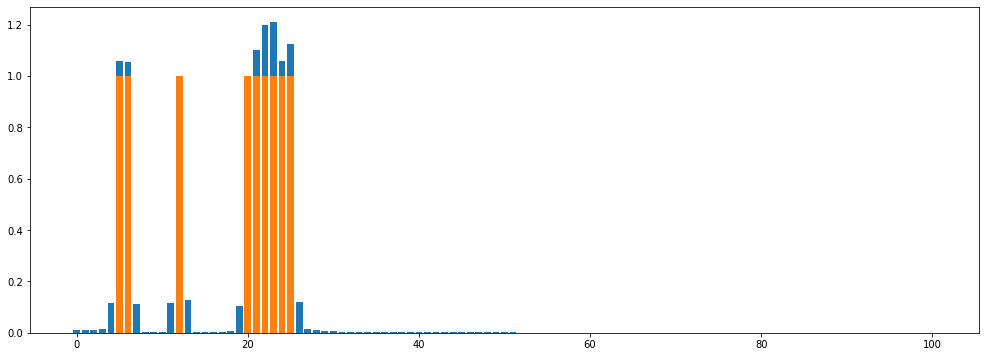

In [27]:
plt.bar(range(101), bands / 80)
plt.bar(range(101), controls)
plt.show()

In [28]:
cosine_similarity(bands, controls)

0.9913311532585115